# 01 DMSO parameter estimation

Before estimating the values of the parameters under the drug treatments, we need to estimate them in the control conditions. This is what we do in this notebook. We also included a couple of scripts for data visualization.

For each treatment, the control is a culture where DMSO is added at the same time as the drug would be (48h before differentiation for artemisinin and indomethacin, and upon differentiation for MB3), which means that there are two different controls depending on the drugs: DMSO with pretreatment (or DMSO PT) for artemisinin and indomethacin, and DMSO without pretreatment (or DMSO) for MB3. The control to be used is defined in the initialization cell, using the Control variable (0 for DMSO PT, 3 for DMSO).

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imp import reload

from itertools import combinations

import SCB_estimate as SCBe
import Custom_Estimation_Routines as CER
import Error_Model as EM
import Selection_Criteria as SC
import Profile_Likelihood as PL

%matplotlib inline

Experiments=(1, 2, 3) #Datasets to be loaded
Treatments=('DMSO_PT','Arte','Indo','DMSO','MB3') #Treatments to be loaded
Control = 3 #Index of the control treatment (0 for DMSO with pretreatment, 3 for DMSO without pretreatment)
duration= 5 #number of timepoints

N=len(Experiments)
m=len(Treatments)

Data=np.empty((N,m,3,duration))

for i in range(N):
    for j in range(m):
        data=np.genfromtxt('../data/Cell_counts_%i_%s.csv'%(Experiments[i], Treatments[j]))
        Data[i,j]=data[:,:duration]

#print(Data.shape)
t=np.arange(duration)
T=np.linspace(0,duration-1)

## Data visualization

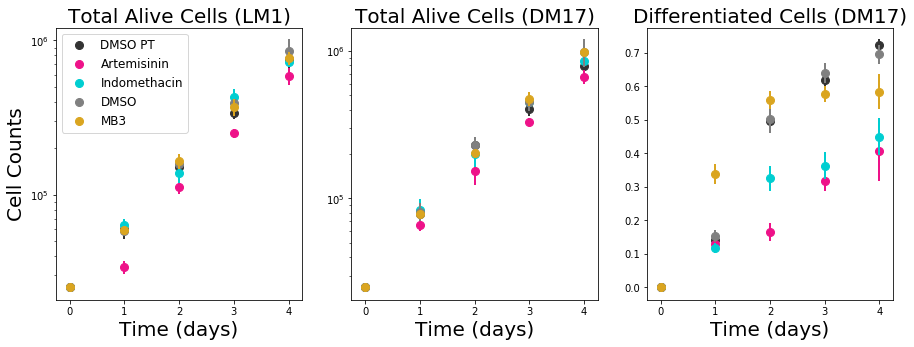

In [24]:
from matplotlib.legend_handler import HandlerLine2D

Labels = ('DMSO PT', 'Artemisinin', 'Indomethacin', 'DMSO', 'MB3')

plt.rcParams['figure.figsize']=15,5
f,ax=plt.subplots(1,3)

xtitles=Experiments
ytitles=['Total Alive Cells (LM1)','Total Alive Cells (DM17)','Differentiated Cells (DM17)']
colors=('0.2','#ee1289ff','#00ced1ff','0.5','#daa520ff')

DataViz = np.empty((N,m,3,duration))

DataViz[:,:,0] = Data[:,:,0]
DataViz[:,:,1] = Data[:,:,1]
DataViz[:,:,2] = Data[:,:,2] / Data[:,:,1]

for j in range(3): #columns of the plot: variables
    for k in range(m): #treatments
        ax[j].plot(t, np.mean(DataViz, axis=0)[k, j],'o',c=colors[k], alpha=1, markersize=8, markeredgecolor=colors[k], label=Labels[k])
        for l in range(duration): #timepoints
            ax[j].plot([t[l], t[l]], [np.mean(DataViz, axis=0)[k, j, l] - np.std(DataViz, axis=0)[k,j,l], np.mean(DataViz, axis=0)[k, j, l] + np.std(DataViz, axis=0)[k,j,l]], '-',c=colors[k], alpha=1, linewidth=2)   
ax[0].set_ylabel('Cell Counts',fontsize=20)
ax[0].legend(loc='best', fontsize=12)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

for j in range(3):
    ax[j].set_title(ytitles[j],fontsize=20)
    ax[j].set_xlabel('Time (days)',fontsize=20)
    ax[j].set_xlim(-0.25,duration -0.75)
    #ax[j].set_yscale('log')

savefig=False
if savefig:
    plt.savefig('../figures/01_DMSO_parameter_estimation/Data.pdf', dpi='figure', bbox_inches='tight')

## DMSO Parameter estimation

In [25]:
Parameters=[r'$\rho_S$',r'$\delta_{SC}$',r'$b_1$',r'$\rho_C$',r'$\delta_{CB}$',r'$\rho_B$',r'$b_2$']
Bounds=[(None,None),(0,None),(None,None),(0,None),(None,None),(0,None)]

estimate_distr=True
estimate_individuals = True

#Optimization parameters:
nruns1=100 #number of independent runs of the first optimization step
nruns2=500 #number of independent runs of the second optimization step
LHS=False #should we perform LHS on initial guesses (apparently, it's not working very well with proportional error)
maxiter=int(1e6)  #maximum duration (in evaluations of the model) of one %run

if estimate_distr:
    print('All data')
    Params_distr=np.empty(7)
    opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                     2,
                     (Data[:,Control,0],SCBe.S,t,Data[0,Control,0,0],np.array([]),False),
                     bounds=Bounds[:2],
                     nsamples=nruns1,
                     lhs=LHS,
                     maxeval=maxiter,
                     output_likelihood=True,
                     verbose_success=False,
                     verbose_error=False)
    rhoS,b1=opt1['parameters']
    deltaSC=rhoS+0.5*np.log(Data[0,Control,0,0])

    opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                     4,
                     (Data[:,Control,1:], SCBe.TB, t, [Data[0,Control,1,0],0,0], np.array([rhoS,deltaSC]), False),
                     bounds=Bounds[2:],
                     nsamples=nruns2,
                     lhs=LHS,
                     maxeval=maxiter,
                     output_likelihood=True,
                     verbose_success=False,
                     verbose_error=False)
    rhoC,deltaCB,rhoB,b2=opt2['parameters']
    Params_distr=rhoS, deltaSC, b1, rhoC, deltaCB, rhoB, b2

if estimate_individuals:
    Params_indiv=np.empty((N,7))
    for i in range(N):
        print(Experiments[i])
        opt1=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         2,
                         (Data[i,Control,0],SCBe.S,t,Data[i,Control,0,0],np.array([]),False),
                         bounds=Bounds[:2],
                         nsamples=nruns1,
                         lhs=LHS,
                         maxeval=maxiter,
                         output_likelihood=True,
                         verbose_success=False,
                         verbose_error=False)
        rhoS,b1=opt1['parameters']
        deltaSC=rhoS+0.5*np.log(Data[i,Control,0,0])
        
        opt2=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         4,
                         (Data[i,Control,1:], SCBe.TB, t, [Data[i,Control,1,0],0,0], np.array([rhoS,deltaSC]),False),
                         bounds=Bounds[2:],
                         nsamples=nruns2,
                         lhs=LHS,
                         maxeval=maxiter,
                         output_likelihood=True,
                         verbose_success=False,
                         verbose_error=False)
        rhoC,deltaCB,rhoB,b2=opt2['parameters']
        
        Params_indiv[i]=rhoS, deltaSC, b1, rhoC, deltaCB, rhoB, b2

All data
1
2
3


In [26]:
save = False
if save:
    if estimate_individuals:
        for i in range(N):
            np.savetxt('../data/01_DMSO_parameter_estimation/Experiment_%i_%id_%s.params'%(Experiments[i],duration-1,Treatments[Control]), Params_indiv[i])
    if estimate_distr:
        np.savetxt('../data/01_DMSO_parameter_estimation/Experiments_%i-%i_%id_%s.params'%(Experiments[0], Experiments[-1], duration-1, Treatments[Control]), Params_distr)

In [27]:
load = True

if load:
    Params_distr = np.genfromtxt('../data/01_DMSO_parameter_estimation/Experiments_%i-%i_%id_%s.params'%(Experiments[0], Experiments[-1], duration-1, Treatments[Control]))
    Params_indiv=np.empty((N,7))
    for i in range(N):
        Params_indiv[i] = np.genfromtxt('../data/01_DMSO_parameter_estimation/Experiment_%i_%id_%s.params'%(Experiments[i],duration-1,Treatments[Control]))

rhoS, deltaSC, b1, rhoC, deltaCB, rhoB, b2 = Params_distr
print('\t', Params_distr)

	 [0.89887812 5.96219368 0.09349134 1.20556551 0.53471071 0.61102852
 0.23589755]


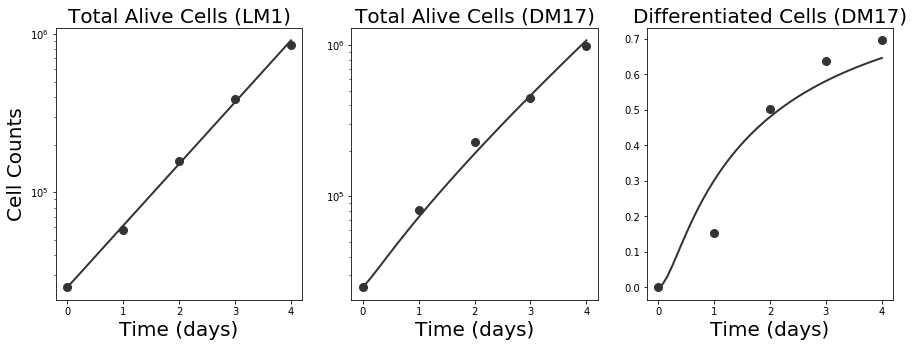

In [28]:
T = np.linspace(0,duration-1)
Ssim=SCBe.S(T, Data[0,Control,0,0], rhoS)
TBsim = SCBe.TB(T, [Data[0,Control,1,0], 0, 0], rhoS, deltaSC, rhoC, deltaCB, rhoB)
Simul=np.vstack((Ssim, TBsim))
Simul[2]/=Simul[1]

plt.rcParams['figure.figsize']=15,5
f,ax=plt.subplots(1,3)

#for i in range(N): #rows of the plot: experiments
for j in range(3): #columns of the plot: variables
    ax[j].plot(t,np.mean(DataViz, axis=0)[Control, j],'o',c='0.2',markersize=8, markeredgecolor='0.2')
    ax[j].plot(T, Simul[j],'-', c='0.2', linewidth=2)
    ax[j].set_title(ytitles[j],fontsize=20)
    ax[j].set_xlabel('Time (days)',fontsize=20)

ax[0].set_ylabel('Cell Counts',fontsize=20)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

savefig=False
if savefig:
    plt.savefig('../figures/01_DMSO_parameter_estimation/%s_fit_avg.pdf'%Treatments[Control], bbox_inches='tight', dpi='figure')